# How meaningful are Gaussian ODE filter uncertainties?

We investigate whether the uncertaintes returned by Gaussian ODE Filters are meaningful as actual error estimates---or even better?


In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('../../probnum.mplstyle')

In [2]:
import numpy as np

import probnum.diffeq as diffeq
from probnum.diffeq import IVP
from probnum.diffeq import lotkavolterra
from probnum import random_variables as rvs
from probnum.diffeq import logistic, probsolve_ivp

We start with the Lotka-Volterra equations.

In [3]:
initdist = rvs.Constant(np.array([20.0, 20.0]))

lv = lotkavolterra([0.0, 50.0], initdist)

The Kalman ODE filter is quite fast and flexible, but does not yield accurate uncertainty estimates. We see below that the uncertainty increases monotonously, independent on the actual peaks and valleys of the ODE solution.

It is not surprising that the Kalman solution is agnostic of the trajectory. In fact, the covariance of the Kalman filter is independent of the data and as such, we cannot expect it to return useful uncertainty.

In [4]:
sol = probsolve_ivp(lv, method="ekf0", which_prior="ibm1", step=0.1)

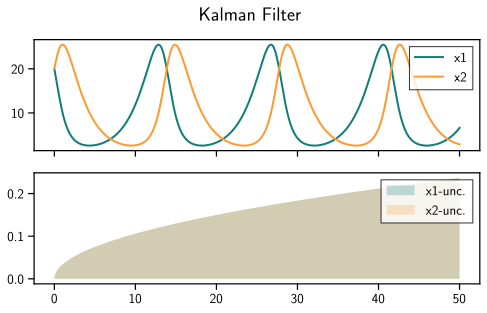

In [5]:
means, stds = sol.y.mean, sol.y.std

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(sol.t, means[:, 0], label="x1")
ax1.plot(sol.t, means[:, 1], label="x2")
ax1.legend()
ax2.fill_between(sol.t, stds[:, 0], alpha=0.25, label="x1-unc.")
ax2.fill_between(sol.t, stds[:, 1], alpha=0.25, label="x2-unc.")
ax2.legend()
fig.suptitle("Kalman Filter")
plt.show()

If instead of the Kalman filter, we use the Extended Kalman filter, the uncertainties are not independent of the measurements (information about $f$ enters the covariance via $\nabla f$ in the measurement model). We can see that in the uncertainty plot below.

In [6]:
sol = probsolve_ivp(lv, method="ekf1", which_prior="ibm1", step=0.01)

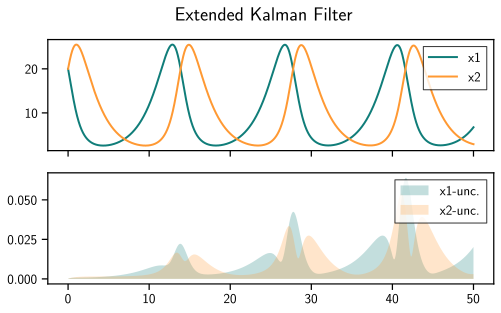

In [7]:
means, stds = sol.y.mean, sol.y.std

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(sol.t, means[:, 0], label="x1")
ax1.plot(sol.t, means[:, 1], label="x2")
ax1.legend()
ax2.fill_between(sol.t, stds[:, 0], alpha=0.25, label="x1-unc.")
ax2.fill_between(sol.t, stds[:, 1], alpha=0.25, label="x2-unc.")
ax2.legend()
fig.suptitle("Extended Kalman Filter")
plt.show()

Notice that the uncertainties are aware of the peaks and valleys. They even know whether the peak is flat (rhs of blue, lhs of orange; smaller ones of the blue peaks) or steep. On top of that, they increase over time.

For both we can also sample from the solution. Let us compute a low-res solution (so the samples actually look different from each other).

Beware, because large numbers of samples can take a long time to compute.

In [8]:
sol = probsolve_ivp(lv, method="ekf0", which_prior="ibm1", step=0.5)

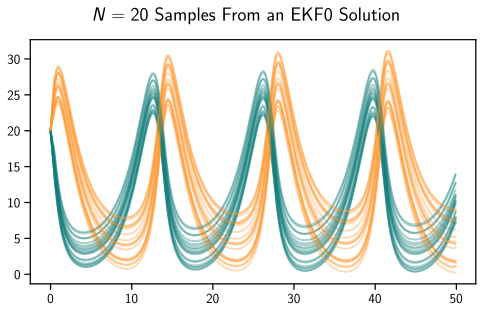

In [9]:
num_samples = 20
locations = np.arange(0., 50., 0.1)
samples = sol.sample(locations, size=num_samples)
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True)
for sample in samples:
    ax1.plot(locations, sample[:, 0], color="C0", alpha=7./num_samples)
    ax1.plot(locations, sample[:, 1], color="C1", alpha=7./num_samples)
fig.suptitle(f"$N={num_samples}$ Samples From an EKF0 Solution")
plt.show()